# Breast Cancer Diagnosis: Machine Learning Classification
## Wisconsin Diagnostic Breast Cancer Dataset Analysis

This notebook implements a comprehensive machine learning pipeline for binary classification of breast cancer diagnoses using the Wisconsin Diagnostic Breast Cancer (WDBC) dataset.
- dataset: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

### Project Overview

This project demonstrates:
- Data preprocessing and exploration
- Feature selection and engineering
- Model training with multiple algorithms
- Comprehensive performance evaluation
- Feature importance analysis
- Correlation analysis

---


## 1. Setup and Data Loading

### Import Required Libraries


In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import (
    silhouette_score, precision_score, recall_score, confusion_matrix,
    roc_curve, precision_recall_curve, accuracy_score, classification_report, f1_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import SelectKBest, f_classif

# Plotly setup
py.init_notebook_mode(connected=True)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
path = "dataset/breast+cancer+wisconsin+diagnostic/wdbc.data"
columns = [
    'ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst',
    'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
data = pd.read_csv(path, header=None, names=columns)

In [3]:
data.head()

,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
print(data.columns)

Index(['ID', 'Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


## 2. Data Preprocessing


The ID column is not useful for classification, so we drop it.


In [5]:
data = data.drop(['ID'],axis = 1)

In [6]:
print(data.columns)

Index(['Diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


In [7]:
data['Diagnosis'].dtype

dtype('O')

In [8]:
numerical_columns = data.select_dtypes(include=[ 'float64','int32']).columns
categorical_columns = data.select_dtypes(include=['object']).columns

**For numerical columns:** Fill missing values with the column mean

In [9]:
for col in numerical_columns:
    data[col] = data[col].fillna(data[col].mean())

**For categorical columns:** Replace unknown values and fill NaN

In [10]:
data[categorical_columns] = data[categorical_columns].replace(['Missing', 'not applicable', 'not available'] , 'Unknown')
data[categorical_columns] = data[categorical_columns].fillna('Unknown')

Ensure all categorical data is string type

In [11]:
for col in categorical_columns:
    data[col] = data[col].astype(str)

In [12]:
numerical_columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [13]:
categorical_columns

Index(['Diagnosis'], dtype='object')

Convert categorical variables to numerical format using LabelEncoder.


In [14]:
# Encode categorical data
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [15]:
# Define the target column
target_column = 'Diagnosis'

# Separate features (X) and labels (y)
X = data.drop(columns=[target_column])
y = data[target_column]

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"\nClass distribution:\n{y.value_counts()}")


Features shape: (569, 30)
Labels shape: (569,)

Class distribution:
Diagnosis
0    357
1    212
Name: count, dtype: int64


## 3. Exploratory Data Analysis (EDA)

Diagnosis Distribution

In [16]:
# plot percentage of data
trace = go.Pie(
    labels=['Benign', 'Malignant'],
    values=data[target_column].value_counts(),
    textfont=dict(size=15),
    opacity=0.8,
    marker=dict(colors=['green', 'red'], line=dict(width=1.5))
)

layout = go.Layout(title='Distribution of Diagnosis Variable')
fig = go.Figure(data=[trace], layout=layout)
fig.show()

### Standardize Features

Scale numerical features to have mean=0 and standard deviation=1. This is crucial for algorithms like Logistic Regression and Neural Networks.


In [17]:
# Standardize numerical columns
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

print("Features standardized successfully")
print(f"Feature means (should be ~0): {X[numerical_columns].mean().round(4).head()}")
print(f"Feature stds (should be ~1): {X[numerical_columns].std().round(4).head()}")

Features standardized successfully
Feature means (should be ~0): radius_mean       -0.0
texture_mean       0.0
perimeter_mean    -0.0
area_mean         -0.0
smoothness_mean   -0.0
dtype: float64
Feature stds (should be ~1): radius_mean        1.0009
texture_mean       1.0009
perimeter_mean     1.0009
area_mean          1.0009
smoothness_mean    1.0009
dtype: float64


### Feature Selection  

Select the top 10 most important features using f-classif score.


In [18]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()].tolist()
print(f"Top 10 selected features: {selected_features}")

Top 10 selected features: ['radius_mean', 'perimeter_mean', 'area_mean', 'concavity_mean', 'concave_points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concavity_worst', 'concave_points_worst']


## 4. Train-Test Split


In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")
print(f"Training set class distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Testing set class distribution:\n{pd.Series(y_test).value_counts()}")

Training set size: (455, 30)
Testing set size: (114, 30)
Training set class distribution:
Diagnosis
0    286
1    169
Name: count, dtype: int64
Testing set class distribution:
Diagnosis
0    71
1    43
Name: count, dtype: int64


## 5. Model Development and Training


###  Model Selection and Rationale

#### 1. Logistic Regression
- Simple, interpretable model ideal for binary classification
- Assumes linear relationship between features and log-odds
- Fast training and inference
- Works well when data is nearly linearly separable
- Provides direct probability estimates

#### 2. XGBoost with Calibration (CalibratedClassifierCV)
- Powerful gradient boosting algorithm for complex non-linear relationships
- Handles feature interactions effectively
- Robust to irrelevant or noisy features
- Calibrated version improves probability predictions
- Excellent for medical applications requiring accurate risk estimates

#### 3. Multilayer Perceptron (MLP)
- Neural network capable of learning intricate non-linear patterns
- Handles high-dimensional data well
- Adaptive learning rate improves convergence
- Complementary to linear models
- Works particularly well with standardized features

### Train and Evaluate Models


In [20]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=200,
        solver='liblinear',
        C=0.1,
        random_state=RANDOM_STATE
    ),

    "XGBoost (Calibrated)": CalibratedClassifierCV(
        XGBClassifier(
            n_estimators=200,
            max_depth=5,
            learning_rate=0.1,
            subsample=0.2,
            colsample_bytree=0.2,
            random_state=RANDOM_STATE
        ),
        method='sigmoid',
        cv=2
    ),

    "MLP Neural Network": MLPClassifier(
        hidden_layer_sizes=(10,),
        learning_rate='adaptive',
        learning_rate_init=0.001,
        activation='logistic',
        solver='adam',
        max_iter=500,
        random_state=RANDOM_STATE
    )
}


Training and evaluating: Logistic Regression
Accuracy:  0.9912
Precision: 0.9913
Recall:    0.9912
F1 Score:  0.9912

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        71
   Malignant       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



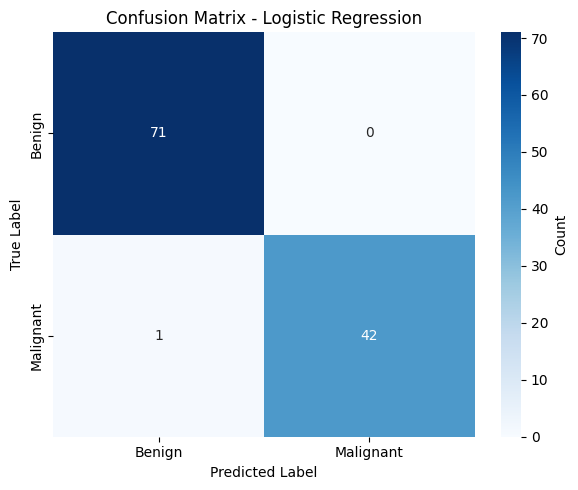


Training and evaluating: XGBoost (Calibrated)
Accuracy:  0.9912
Precision: 0.9913
Recall:    0.9912
F1 Score:  0.9912

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        71
   Malignant       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



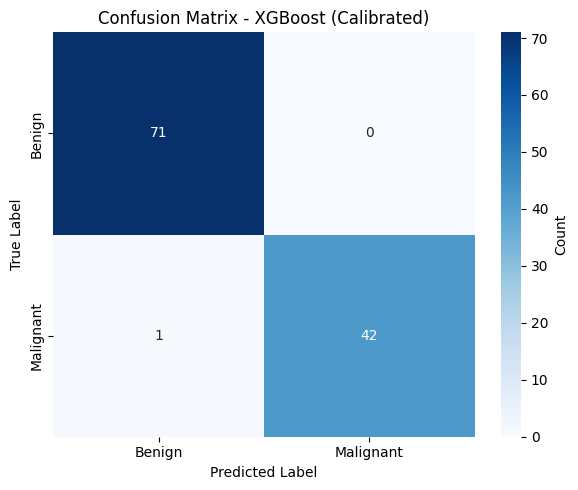


Training and evaluating: MLP Neural Network
Accuracy:  0.9912
Precision: 0.9913
Recall:    0.9912
F1 Score:  0.9912

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.99      1.00      0.99        71
   Malignant       1.00      0.98      0.99        43

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114



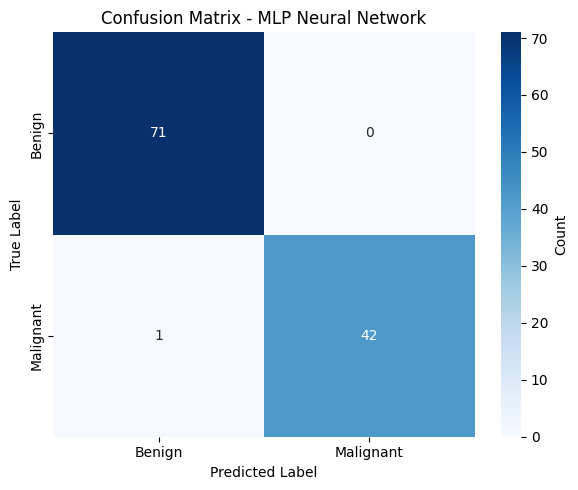


Model Comparison Summary
                      Accuracy  Precision  Recall  F1 Score
Logistic Regression     0.9912     0.9913  0.9912    0.9912
XGBoost (Calibrated)    0.9912     0.9913  0.9912    0.9912
MLP Neural Network      0.9912     0.9913  0.9912    0.9912


In [21]:
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"Training and evaluating: {name}")
    print(f"{'='*60}")

    # Train
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store results
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Display metrics
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Benign', 'Malignant'],
        yticklabels=['Benign', 'Malignant'],
        cbar_kws={'label': 'Count'}
    )
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Results summary
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("Model Comparison Summary")
print("="*60)
print(results_df.round(4))

In [22]:
# Results summary
results_df = pd.DataFrame(results).T
print("\n" + "="*60)
print("Model Comparison Summary")
print("="*60)
print(results_df.round(4))


Model Comparison Summary
                      Accuracy  Precision  Recall  F1 Score
Logistic Regression     0.9912     0.9913  0.9912    0.9912
XGBoost (Calibrated)    0.9912     0.9913  0.9912    0.9912
MLP Neural Network      0.9912     0.9913  0.9912    0.9912


## 6. Feature Importance Analysis


###  Logistic Regression - Coefficient Importance


Top 15 Features by Importance (Logistic Regression):
                 Feature  Importance
21         texture_worst    0.583456
20          radius_worst    0.493864
10             radius_se    0.490999
7    concave_points_mean    0.472338
23            area_worst    0.471812
28        symmetry_worst    0.469900
27  concave_points_worst    0.450276
22       perimeter_worst    0.438282
1           texture_mean    0.406755
26       concavity_worst    0.404306
13               area_se    0.397576
24      smoothness_worst    0.384898
6         concavity_mean    0.378750
3              area_mean    0.374869
0            radius_mean    0.360441


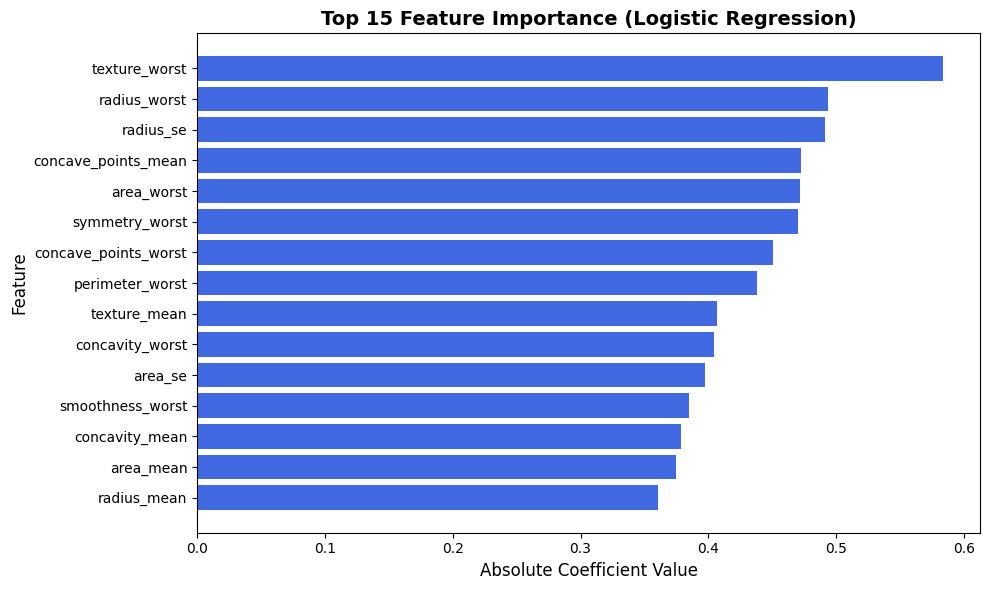

In [23]:
log_reg = LogisticRegression(max_iter=200, solver='liblinear', C=0.1, random_state=RANDOM_STATE)
log_reg.fit(X_train, y_train)

# Extract absolute coefficient values as feature importance
feature_importance = np.abs(log_reg.coef_[0])
feature_names = X.columns

lr_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print("Top 15 Features by Importance (Logistic Regression):")
print(lr_importance_df.head(15))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(lr_importance_df['Feature'][:15], lr_importance_df['Importance'][:15], color='royalblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importance (Logistic Regression)', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Coefficient Value', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

###  XGBoost - Tree-based Importance


Top 15 Features by Importance (XGBoost):
                 Feature  Importance
20          radius_worst    0.115133
27  concave_points_worst    0.103637
23            area_worst    0.086009
26       concavity_worst    0.066850
10             radius_se    0.062796
0            radius_mean    0.052518
7    concave_points_mean    0.052287
13               area_se    0.050853
21         texture_worst    0.029872
28        symmetry_worst    0.026092
12          perimeter_se    0.025241
18           symmetry_se    0.024704
1           texture_mean    0.024495
22       perimeter_worst    0.023070
2         perimeter_mean    0.021965


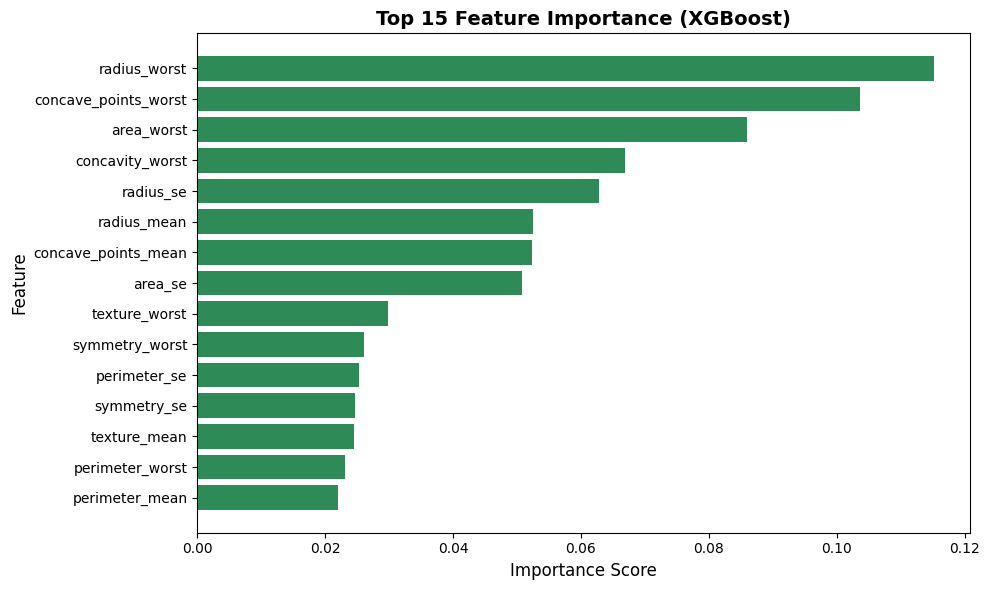

In [24]:
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.2,
    colsample_bytree=0.2,
    random_state=RANDOM_STATE
)
xgb_model.fit(X_train, y_train)

xgb_importance = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)

print("Top 15 Features by Importance (XGBoost):")
print(xgb_importance_df.head(15))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df['Feature'][:15], xgb_importance_df['Importance'][:15], color='seagreen')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

### MLP - Permutation Importance


Top 15 Features by Importance (MLP):
                   Feature  Importance
10               radius_se    0.023684
9   fractal_dimension_mean    0.020175
15          compactness_se    0.018421
28          symmetry_worst    0.018421
7      concave_points_mean    0.017544
20            radius_worst    0.017544
19    fractal_dimension_se    0.016667
27    concave_points_worst    0.013158
24        smoothness_worst    0.013158
23              area_worst    0.012281
21           texture_worst    0.011404
22         perimeter_worst    0.010526
3                area_mean    0.010526
13                 area_se    0.010526
2           perimeter_mean    0.010526


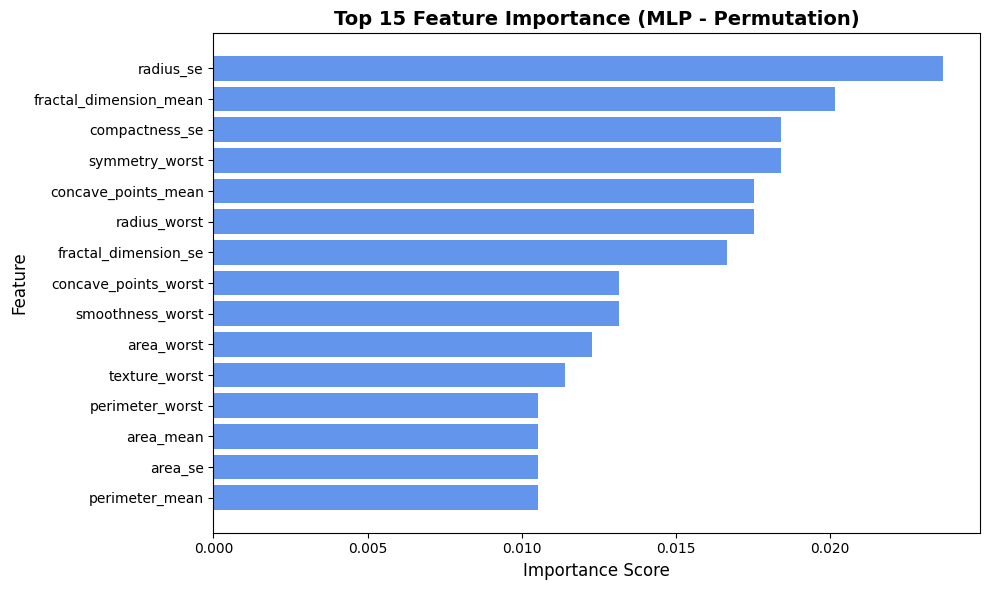

In [25]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=(10,),
    learning_rate='adaptive',
    learning_rate_init=0.001,
    activation='logistic',
    solver='adam',
    max_iter=500,
    random_state=RANDOM_STATE
)
mlp_model.fit(X_train, y_train)

# Calculate permutation importance
mlp_importance = permutation_importance(mlp_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)
mlp_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mlp_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print("Top 15 Features by Importance (MLP):")
print(mlp_importance_df.head(15))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(mlp_importance_df['Feature'][:15], mlp_importance_df['Importance'][:15], color='cornflowerblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importance (MLP - Permutation)', fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Correlation Analysis


### Correlation Matrix Heatmap


In [26]:
correlation = data.corr()
matrix_cols = correlation.columns.tolist()
corr_array = np.array(correlation)

trace = go.Heatmap(
    z=corr_array,
    x=matrix_cols,
    y=matrix_cols,
    xgap=2,
    ygap=2,
    colorscale='Viridis',
    colorbar=dict(title="Correlation")
)

layout = go.Layout(
    title='Correlation Matrix of All Features',
    autosize=False,
    height=720,
    width=800,
    margin=dict(r=0, l=210, t=50, b=210),
    yaxis=dict(tickfont=dict(size=9)),
    xaxis=dict(tickfont=dict(size=9))
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()

### Identify Highly Correlated and Uncorrelated Features

In [27]:
# Extract all correlation pairs
corr_pairs = correlation.stack().reset_index()
corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# Remove self-correlations and duplicates
corr_pairs = corr_pairs[corr_pairs['Feature1'] != corr_pairs['Feature2']]
corr_pairs['abs_corr'] = corr_pairs['Correlation'].abs()

# Sort by absolute correlation
corr_sorted = corr_pairs.sort_values(by='abs_corr', ascending=False).reset_index(drop=True)

print("="*60)
print("Strongest Correlations")
print("="*60)
print(corr_sorted.head(15)[['Feature1', 'Feature2', 'Correlation']])

print("\n" + "="*60)
print("Weakest Correlations")
print("="*60)
print(corr_sorted.tail(15)[['Feature1', 'Feature2', 'Correlation']])

Strongest Correlations
           Feature1         Feature2  Correlation
0       radius_mean   perimeter_mean     0.997855
1    perimeter_mean      radius_mean     0.997855
2      radius_worst  perimeter_worst     0.993708
3   perimeter_worst     radius_worst     0.993708
4       radius_mean        area_mean     0.987357
5         area_mean      radius_mean     0.987357
6    perimeter_mean        area_mean     0.986507
7         area_mean   perimeter_mean     0.986507
8      radius_worst       area_worst     0.984015
9        area_worst     radius_worst     0.984015
10       area_worst  perimeter_worst     0.977578
11  perimeter_worst       area_worst     0.977578
12     perimeter_se        radius_se     0.972794
13        radius_se     perimeter_se     0.972794
14   perimeter_mean  perimeter_worst     0.970387

Weakest Correlations
                    Feature1                 Feature2  Correlation
915  fractal_dimension_worst              radius_mean     0.007066
916             textu

### Visualize Highly Correlated Features


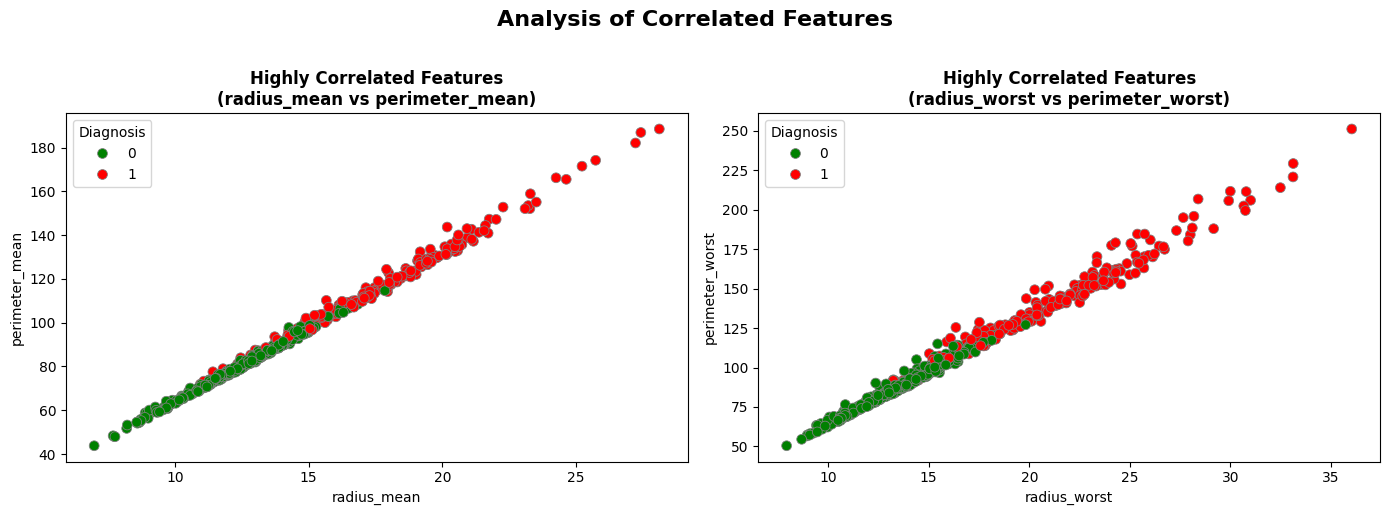

In [28]:
palette = {0: 'green', 1: 'red'}
edgecolor = 'grey'

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Highly correlated features
sns.scatterplot(
    ax=axes[0],
    x=data['radius_mean'],
    y=data['perimeter_mean'],
    hue=data['Diagnosis'],
    palette=palette,
    edgecolor=edgecolor,
    s=50
)
axes[0].set_title('Highly Correlated Features\n(radius_mean vs perimeter_mean)', fontweight='bold')

sns.scatterplot(
    ax=axes[1],
    x=data['radius_worst'],
    y=data['perimeter_worst'],
    hue=data['Diagnosis'],
    palette=palette,
    edgecolor=edgecolor,
    s=50
)
axes[1].set_title('Highly Correlated Features\n(radius_worst vs perimeter_worst)', fontweight='bold')

plt.suptitle('Analysis of Correlated Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Visualize Uncorrelated Features


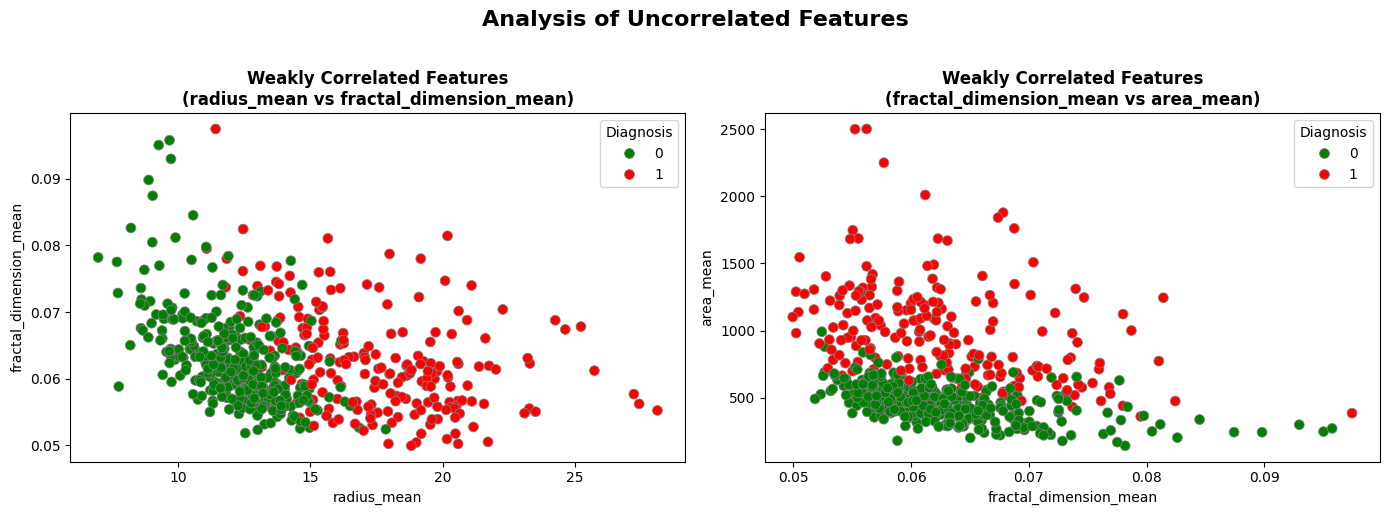

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(
    ax=axes[0],
    x=data['radius_mean'],
    y=data['fractal_dimension_mean'],
    hue=data['Diagnosis'],
    palette=palette,
    edgecolor=edgecolor,
    s=50
)
axes[0].set_title('Weakly Correlated Features\n(radius_mean vs fractal_dimension_mean)', fontweight='bold')

sns.scatterplot(
    ax=axes[1],
    x=data['fractal_dimension_mean'],
    y=data['area_mean'],
    hue=data['Diagnosis'],
    palette=palette,
    edgecolor=edgecolor,
    s=50
)
axes[1].set_title('Weakly Correlated Features\n(fractal_dimension_mean vs area_mean)', fontweight='bold')

plt.suptitle('Analysis of Uncorrelated Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()